# Expedia Hotel Recommendation

Data Description

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

# 1. EDA & Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import missingno as msno
import ml_metrics as metrics

### 1-0. Load Dataset

In [2]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

### 1-1. Check Dataset

In [3]:
# # Data 살펴보기

# print('train.shape :', train.shape)
# print('test.shape :', test.shape)
# print('destinations.shape', destinations.shape)

# # check destinationmissing values
# print(destinations.tail())
# train.tail()
# print(train.info())
# print(test.tail())
# print(test.info())
# train.describe()
# test.describe()
# print(len(train.columns), train.columns)
# print(len(test.columns), test.columns)

- destination.csv
    - row index와 srch_destination_id가 차이나는 것으로 보아, missing된 id가 존재하는 것으로 판단 (대략 5% 미만) -> 어떻게 처리할지? : 비율이 적어 삭제해도 무방할 듯
- train.csv
    - 대부분 integer, float variable
    - date time는 년,월,일,시 등으로 format 변경 필요
    - user_loaction_country, user_location_city value의 정확한 의미 알 수 없어 사용이 어려워 보임 (keep)
    - orig_destination_distance Nan 어떻게 처리할지? --> data description에 의하면 Nan value는 계산이 불가능한 경우 :
        - A null means the distance could not be calculated

- train set 너무 많음(3700만 개) --> 이대로 계속 분석 가능한지?(메모리 이슈) : sampling

### 1-2. Check missing values in train data 

In [4]:
# train.info()

In [5]:
# 각 컬럼 별 빠진 값 확인
def check_missing_value(df):
    for col in df.columns:
        if df[col].dtypes == 'int64' or df[col].dtypes == 'float64':
            unique_count = int(np.array(df[col].nunique()))
            max_number = max(np.array(df[col]))
            min_number = min(np.array(df[col]))
            print('[', col, '] max :', max_number, 'min :', min_number, 
                  'diff : ', max_number-min_number+1, 'unique :', unique_count)

check_missing_value(train)

('[', 'site_name', '] max :', 53, 'min :', 2, 'diff : ', 52, 'unique :', 45)
('[', 'posa_continent', '] max :', 4, 'min :', 0, 'diff : ', 5, 'unique :', 5)
('[', 'user_location_country', '] max :', 239, 'min :', 0, 'diff : ', 240, 'unique :', 237)
('[', 'user_location_region', '] max :', 1027, 'min :', 0, 'diff : ', 1028, 'unique :', 1008)
('[', 'user_location_city', '] max :', 56508, 'min :', 0, 'diff : ', 56509, 'unique :', 50447)
('[', 'orig_destination_distance', '] max :', 12407.9022, 'min :', 0.0056, 'diff : ', 12408.8966, 'unique :', 8495289)
('[', 'user_id', '] max :', 1198785, 'min :', 0, 'diff : ', 1198786, 'unique :', 1198786)
('[', 'is_mobile', '] max :', 1, 'min :', 0, 'diff : ', 2, 'unique :', 2)
('[', 'is_package', '] max :', 1, 'min :', 0, 'diff : ', 2, 'unique :', 2)
('[', 'channel', '] max :', 10, 'min :', 0, 'diff : ', 11, 'unique :', 11)
('[', 'srch_adults_cnt', '] max :', 9, 'min :', 0, 'diff : ', 10, 'unique :', 10)
('[', 'srch_children_cnt', '] max :', 9, 'min :'

- Missing values
    - site name : 7
    - posa_continent : 0
    - user_location_country : 3
    - user_location_region : 20 (unknown meaning)
    - user_location_city : 6062 (unknown meaning)
    - orig_destination_distance : too much (continuous value) (will be checked)
    - user_id : 0
    - is_mobile : 0
    - is_package : 0
    - channel : 0
    - srch_adults_cnt : 0
    - srch_children_cnt : 0
    - srch_rm_cnt : 0
    - srch_destination_id : 653 (in 65108) (will be checked)
    - srch_destination_type_id : 0
    - is_booking : 0
    - hotel_continent : 0
    - hotel_country: 0
    - hotel_market : 0
    - hotel_cluster : 0

### 1-3. Check Nan values in data 

In [6]:
def check_nan(df):
    for col in df.columns:
        msg = '{:>10}\t\t\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df[col].isnull().sum() / df[col].shape[0]))
        print(msg)

In [7]:
# missing value 확인

# print(check_nan(train))
# print(check_nan(test))

- Train.csv column
    - ID 없음
- test.csv column
    - missing value 없음
    - is_booking, cnt, hotel_cluster(label) column 없음

In [8]:
def check_nan_col(df, col_list):
    for cl in col_list:
        Nan_idx = list(df.loc[df[cl].isnull()][cl].index)
        print('Nan of', cl, ': ', len(Nan_idx))

In [9]:
# train에만 결측치 있음
print(check_nan_col(train, ['srch_ci', 'srch_co']))

('Nan of', 'srch_ci', ': ', 47083)
('Nan of', 'srch_co', ': ', 47084)
None


- Checkin data와 Checkout data의 누락이 대부분 겹치치만, 각각 누락된 것도 있음
- data description에 의하면 알 수 없는 컬럼이며, 전체 데이터 비율에 비해 매우 작은 비율을 차지하므로 삭제

In [10]:
# delete srch_ci, srch_co nan row 
def delete_nan_col(df, col_list):
    df.dropna(subset=col_list, axis=0, inplace=True)

In [11]:
delete_nan_col(train, ['srch_ci', 'srch_co'])
print(check_nan_col(train, ['srch_ci', 'srch_co']))

('Nan of', 'srch_ci', ': ', 0)
('Nan of', 'srch_co', ': ', 0)
None


- Train set의 srch_ci, srch_co 결측치 삭제 완료

In [12]:
# missing value 비율 확인

# msno.bar(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.bar(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

### 1-3. Delete checkin/checkout error rows

In [13]:
io_error_idx = train[train['srch_ci'] > train['srch_co']].index
train.drop(index=io_error_idx, inplace=True)

### 1-4. Check label data distribution

('min:', 48275, 'max:', 1042545)


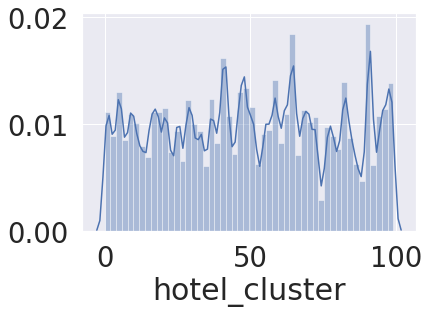

In [14]:
train['hotel_cluster'].value_counts()
sns.distplot(train['hotel_cluster'])
print('min:',min(train['hotel_cluster'].value_counts()), 'max:',max(train['hotel_cluster'].value_counts()))

### 1-5. Convert Dates to Year & Month for original Train/Test set

In [15]:
train['date_time'] = pd.to_datetime(train['date_time'])
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
# print(train.head())

In [16]:
test['date_time'] = pd.to_datetime(test['date_time'])
test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day
# print(test.head())

### 1-6. Remove not booking user data

In [17]:
# userid_isbooking_group = train.groupby(['user_id'])['is_booking'].value_counts()
isbooking_user_group = train.groupby(['is_booking'])['user_id'].value_counts()

booking_user_list = train[train.is_booking == 1].user_id.tolist() # user_id idx list that book at least once
# print(real_user_list)

In [18]:
train_booking = train.loc[booking_user_list, :]
# train.info()

### [PASS] 1-6. Downsizing dataset by User random sampling (not for train_booking, Try2)

In [19]:
# # 전체 데이터 활용하는 경우, user random sampling을 위한 유저 수 구하기

# train_userid_group = train.groupby(['user_id'])['hotel_cluster'].value_counts()

# print('[train] unique user count :',train['user_id'].nunique())
# print('[test] unique user count :',test['user_id'].nunique())

- 1,198,786 user -> 100,000 user random sampling (Considering computation resource)

In [20]:
# sampling_size = 100000

In [21]:
# # 유저 랜덤샘플링

# def random_sampling(df, key_col, sampling_size, origin_file, chunk_size):
#     unique_set = set(df[key_col].unique())
#     sampling_set = random.sample(unique_set, sampling_size)

#     df_sampling = pd.DataFrame()
#     df_chunking = pd.read_csv(origin_file, chunksize = chunk_size) 

#     for c in df_chunking:
#         df_sampling = df_sampling.append(c.loc[c[key_col].isin(sampling_set)])
        
#     return df_sampling

In [22]:
# train_sampling = random_sampling(df=train, key_col='user_id', sampling_size=sampling_size, origin_file='train.csv', chunk_size=100000)
# print('sampling unique user count :',train_sampling['user_id'].nunique())    

In [23]:
# train_origin = pd.DataFrame.copy(train)

In [24]:
train_booking['date_time'] = pd.to_datetime(train_booking['date_time'])
train_booking['year'] = train_booking['date_time'].dt.year
train_booking['month'] = train_booking['date_time'].dt.month
train_booking['day'] = train_booking['date_time'].dt.day
# train_sampling.head()

In [25]:
# train_origin['date_time'] = pd.to_datetime(train_origin['date_time'])
# train_origin['year'] = train_origin['date_time'].dt.year
# train_origin['month'] = train_origin['date_time'].dt.month
# train_origin['day'] = train_origin['date_time'].dt.day
# # train_origin.head()

In [26]:
# train_sampling['date_time'] = pd.to_datetime(train_sampling['date_time'])
# train_sampling['year'] = train_sampling['date_time'].dt.year
# train_sampling['month'] = train_sampling['date_time'].dt.month
# train_sampling['day'] = train_sampling['date_time'].dt.day

In [27]:
# # delete srch_ci, srch_co nan row in train_sampling
# train_sampling.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

In [28]:
# train_origin.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

In [29]:
train_booking.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

In [30]:
# orig_destination_distance 
# print(train_sampling['orig_destination_distance'].median(skipna=True))
# print(train_sampling['orig_destination_distance'].mean(skipna=True))
# train_sampling['orig_destination_distance'].describe()
# train_sampling.groupby(['user_id'])['orig_destination_distance'].describe()

In [32]:
# hotel_distance = train_sampling.groupby(['hotel_cluster'])['orig_destination_distance'].describe()
# print(hotel_distance)

In [33]:
hotel_distance = train_booking.groupby(['hotel_cluster'])['orig_destination_distance'].describe()
# print(hotel_distance)

- orig_destination_distance missing value
    - 거리개념이라 음수또는 0으로 처리하기엔 좋지 않음
    - 전체 mean, median을 일괄적용하기에는 Nan 비율이 너무 높음
    - 각 유저별 mean 또는 median을 고려하기엔 user_id별 로그가 전혀없는 것들이 있음
    - Hotel_cluster별 mean을 적용해보자

In [34]:
# train_booking.info()

In [35]:
def fill_distance_by_cluster(df): # can use this func if the df has the 'hotel_cluster' column
    hotel_distance = df.groupby(['hotel_cluster'])['orig_destination_distance'].describe()
    cluster_avg_distance = pd.DataFrame(hotel_distance['mean'].tolist(), columns=['avg_distance'])
    cluster_avg_distance['hotel_cluster'] = pd.DataFrame(cluster_avg_distance.index.tolist())

    df = pd.merge(df, cluster_avg_distance, how='inner', on='hotel_cluster', left_index=True)
    df.orig_destination_distance.fillna(df['avg_distance'], inplace=True)
    df = df.drop("avg_distance", axis=1)
    
    return df

In [36]:
# train_sampling = fill_distance_by_cluster(train_sampling)

In [37]:
# train_origin = fill_distance_by_cluster(train_origin)

In [38]:
train_booking = fill_distance_by_cluster(train_booking)

In [39]:
# train_sampling.info()

In [40]:
# train_sampling.groupby(['year'])['month'].value_counts()
# train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()
# train_sampling.groupby(['hotel_cluster'])['user_id'].value_counts()
# print(min(train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()))
# print(max(train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()))
# train_sampling.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()

In [41]:
# print(min(train_sampling.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()))
# print(max(train_sampling.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()))

In [42]:
print(min(train_booking.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()))
print(max(train_booking.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()))

1
22040


In [43]:
check_nan(train_booking)

 date_time			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 0.00%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Percent of NaN value: 0.00%
is_package			 Percent of NaN value: 0.00%
   channel			 Percent of NaN value: 0.00%
   srch_ci			 Percent of NaN value: 0.00%
   srch_co			 Percent of NaN value: 0.00%
srch_adults_cnt			 Percent of NaN value: 0.00%
srch_children_cnt			 Percent of NaN value: 0.00%
srch_rm_cnt			 Percent of NaN value: 0.00%
srch_destination_id			 Percent of NaN value: 0.00%
srch_destination_type_id			 Percent of NaN value: 0.00%
is_booking			 Percent of NaN value: 0.00%
       cnt			 Percent of NaN value: 0.00%
hotel_continent			 Percent of NaN value: 0.00%
hotel_country			 Percent of N

In [44]:
# check_nan(train_origin)

### 1-6. Feature correlation analysis

In [45]:
# train.corr()[train.corr() > 0.5] # run just once 

In [46]:
# train.corr()['hotel_cluster']

In [47]:
# most missing feature : orig_destination_distance 
# Physical distance between a hotel and a customer at the time of search. 
# A null means the distance could not be calculated
# train.corr()['orig_destination_distance']

In [48]:
# train.corr()['srch_destination_id']

- data description에 의해 직관적으로 중요해보이는 column에 대한 correlation 분석 실시
- hotel_cluster와 선형 상관관계가 있는 feature는 없으므로, linear regression은 적합하지 않다고 판단
- ML model을 돌리기 위한 추가 피처 고려 필요 (destination.csv)

### 1-7. Additional feature generation with PCA

In [49]:
# destinations.isnull().sum()
# destinations.tail() 

- srch_destination_id에 결측치 있음

In [50]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=149)
destination_full_components = pca_full.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.95) + 1
print('dim over 95% :', dim)

pca = PCA(n_components=dim)
destination_compression = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(dim)]])
destination_compression = pd.DataFrame(destination_compression)
destination_compression["srch_destination_id"] = destinations["srch_destination_id"]
# print('eigen_value :', pca.explained_variance_)
# print('explained variance ratio :', pca.explained_variance_ratio_)

('dim over 95% :', 59)


- 누적된 분산의 비율이 95%가 되도록 차원 결정

In [51]:
# destination_compression.tail()
# destination_compression.isnull().sum()

### 1-8. Generate new feature

- date_time 관련 time property에 대한 피처 추가
- srch_in, srch_out 관련 date property에 대한 피처 추가
- train_sampling feature와 destinations pca 결과 feature를 concat
- train_sampling data set으로 학습

In [52]:
def merge_features(df): 
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    new_features = {}
    
    # Add time feature of date_time
    kind_of_time = ["quarter", "month", "dayofweek", "day", "hour", "minute"]
    for t in kind_of_time:
        new_features[t] = getattr(df["date_time"].dt, t)
    
    # Add date feature of srch_ci, srch_co & 
    kind_of_date = ["month", "day", "dayofweek", "quarter"]
    for d in kind_of_date:
        new_features["ci_{0}".format(d)] = getattr(df["srch_ci"].dt, d)
        new_features["co_{0}".format(d)] = getattr(df["srch_co"].dt, d)
    new_features["duration_of_stay"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    
    # Add others feature
    column_others = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for c in column_others:
        new_features[c] = df[c]
    
    new_features_df = pd.DataFrame(new_features)
    
    # Concat destinations features
    new_features_df = new_features_df.join(destination_compression, 
                                           on="srch_destination_id", 
                                           how='left', 
                                           rsuffix="destination_compression")
    new_features_df = new_features_df.drop("srch_destination_iddestination_compression", axis=1)

    return new_features_df

In [53]:
train_booking_addition = merge_features(train_booking)

In [54]:
# train_sampling_addition = merge_features(train_sampling)
# train_sampling_addition

In [55]:
# train_origin_addition = merge_features(train_origin)
# train_origin_addition

In [56]:
# train_sampling_addition.tail()
# train_sampling_addition.describe()

In [57]:
# check_nan(train_sampling_addition)

In [58]:
check_nan(train_booking_addition)

   channel			 Percent of NaN value: 0.00%
    ci_day			 Percent of NaN value: 0.00%
ci_dayofweek			 Percent of NaN value: 0.00%
  ci_month			 Percent of NaN value: 0.00%
ci_quarter			 Percent of NaN value: 0.00%
       cnt			 Percent of NaN value: 0.00%
    co_day			 Percent of NaN value: 0.00%
co_dayofweek			 Percent of NaN value: 0.00%
  co_month			 Percent of NaN value: 0.00%
co_quarter			 Percent of NaN value: 0.00%
       day			 Percent of NaN value: 0.00%
 dayofweek			 Percent of NaN value: 0.00%
duration_of_stay			 Percent of NaN value: 0.00%
hotel_cluster			 Percent of NaN value: 0.00%
hotel_continent			 Percent of NaN value: 0.00%
hotel_country			 Percent of NaN value: 0.00%
hotel_market			 Percent of NaN value: 0.00%
      hour			 Percent of NaN value: 0.00%
is_booking			 Percent of NaN value: 0.00%
 is_mobile			 Percent of NaN value: 0.00%
is_package			 Percent of NaN value: 0.00%
    minute			 Percent of NaN value: 0.00%
     month			 Percent of NaN value: 0.00%
orig_destin

- No missing values

In [59]:
# check_nan(train_origin_addition)

In [60]:
train_booking_addition.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2997341 entries, 18 to 27
Data columns (total 96 columns):
channel                      float64
ci_day                       int64
ci_dayofweek                 int64
ci_month                     int64
ci_quarter                   int64
cnt                          float64
co_day                       int64
co_dayofweek                 int64
co_month                     int64
co_quarter                   int64
day                          float64
dayofweek                    int64
duration_of_stay             float64
hotel_cluster                float64
hotel_continent              float64
hotel_country                float64
hotel_market                 float64
hour                         int64
is_booking                   float64
is_mobile                    float64
is_package                   float64
minute                       int64
month                        float64
orig_destination_distance    float64
posa_continent           

### 1-9. srch_destination_id missing value 전략
- is_booking 
- missing value가 많다면 is_booking=1인 데이터에 대해서 matrix factorization 수행하는 방법이 있을듯
- feature 간의 상관관계가 없고, 전체 dataset 중에서 missing value가 차지하는 비율이 매우 적음 (0.19%)
- missing value를 처리하는 여러 방법 중, 제거(Drop)하는 방법을 선택

In [61]:
train_booking_addition.dropna(inplace=True)

In [62]:
# train_sampling_addition.dropna(inplace=True)

In [63]:
# train_origin_addition.dropna(inplace=True)

In [64]:
for col in train_booking_addition.columns:
    print(col, train_booking_addition[col].isnull().sum())

('channel', 0)
('ci_day', 0)
('ci_dayofweek', 0)
('ci_month', 0)
('ci_quarter', 0)
('cnt', 0)
('co_day', 0)
('co_dayofweek', 0)
('co_month', 0)
('co_quarter', 0)
('day', 0)
('dayofweek', 0)
('duration_of_stay', 0)
('hotel_cluster', 0)
('hotel_continent', 0)
('hotel_country', 0)
('hotel_market', 0)
('hour', 0)
('is_booking', 0)
('is_mobile', 0)
('is_package', 0)
('minute', 0)
('month', 0)
('orig_destination_distance', 0)
('posa_continent', 0)
('quarter', 0)
('site_name', 0)
('srch_adults_cnt', 0)
('srch_children_cnt', 0)
('srch_destination_id', 0)
('srch_destination_type_id', 0)
('srch_rm_cnt', 0)
('user_id', 0)
('user_location_city', 0)
('user_location_country', 0)
('user_location_region', 0)
('year', 0)
(0, 0)
(1, 0)
(2, 0)
(3, 0)
(4, 0)
(5, 0)
(6, 0)
(7, 0)
(8, 0)
(9, 0)
(10, 0)
(11, 0)
(12, 0)
(13, 0)
(14, 0)
(15, 0)
(16, 0)
(17, 0)
(18, 0)
(19, 0)
(20, 0)
(21, 0)
(22, 0)
(23, 0)
(24, 0)
(25, 0)
(26, 0)
(27, 0)
(28, 0)
(29, 0)
(30, 0)
(31, 0)
(32, 0)
(33, 0)
(34, 0)
(35, 0)
(36, 0)


In [65]:
# for col in train_sampling_addition.columns:
#     print(col, train_sampling_addition[col].isnull().sum())

In [66]:
# for col in train_origin_addition.columns:
#     print(col, train_origin_addition[col].isnull().sum())

In [67]:
# train_sampling_addition.describe()

In [68]:
# train_sampling_addition = train_sampling_addition.astype(float)
# train_booking_addition.info()

In [69]:
train_booking_addition = train_booking_addition.astype(float)
train_booking_addition.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991747 entries, 18 to 27
Data columns (total 96 columns):
channel                      float64
ci_day                       float64
ci_dayofweek                 float64
ci_month                     float64
ci_quarter                   float64
cnt                          float64
co_day                       float64
co_dayofweek                 float64
co_month                     float64
co_quarter                   float64
day                          float64
dayofweek                    float64
duration_of_stay             float64
hotel_cluster                float64
hotel_continent              float64
hotel_country                float64
hotel_market                 float64
hour                         float64
is_booking                   float64
is_mobile                    float64
is_package                   float64
minute                       float64
month                        float64
orig_destination_distance    float64
pos

# 2. Hotel cluster classification

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

import ml_metrics as metrics
from sklearn.model_selection import train_test_split 
import pickle

import tensorflow as tf
from tensorflow import keras, optimizers

## 2-0. Data preparation (recap)

### Train / Test split by train_sampling (ratio 80:20)
- month 기준으로 분할 (일 기준으로 나눌 수 있지만, 분석의 용이성을 높이고자)
- 24 month data를 8:2로 나누면, 대략 19 : 5 

In [71]:
train_booking_new = train_booking_addition[((train_booking_addition.year == 2013) | ((train_booking_addition.year == 2014) & (train_booking_addition.month <= 7)))]
test_booking_new = train_booking_addition[((train_booking_addition.year == 2014) & (train_booking_addition.month >= 8))]
test_booking_new = test_booking_new[test_booking_new.is_booking == 1]
# test_booking_new

In [72]:
# train_sampling_new = train_sampling_addition[((train_sampling_addition.year == 2013) | ((train_sampling_addition.year == 2014) & (train_sampling_addition.month <= 7)))]
# test_sampling_new = train_sampling_addition[((train_sampling_addition.year == 2014) & (train_sampling_addition.month >= 8))]
# test_sampling_new = test_sampling_new[test_sampling_new.is_booking == 1]
# test_booking_new

In [73]:
# train_origin_new = train_origin_addition[((train_origin_addition.year == 2013) | ((train_origin_addition.year == 2014) & (train_origin_addition.month <= 7)))]
# test_origin_new = train_origin_addition[((train_origin_addition.year == 2014) & (train_origin_addition.month >= 8))]
# test_origin_new = test_origin_new[test_origin_new.is_booking == 1]

In [74]:
# print(check_nan(train_new))
# print(check_nan(test_new))

In [75]:
def make_label(df, target):
    x = df.drop(target, axis=1).values
    y = df[target].values
    
    return x, y

In [76]:
train_booking_x, train_booking_y = make_label(train_booking_new, 'hotel_cluster')
print(train_booking_x.shape)
print(train_booking_y.shape)

valid_booking_x, valid_booking_y = make_label(test_booking_new, 'hotel_cluster')
print(valid_booking_x.shape)
print(valid_booking_y.shape)

(1877022, 95)
(1877022,)
(81356, 95)
(81356,)


In [77]:
# train_x, train_y = make_label(train_new, 'hotel_cluster')
# print(train_x.shape)
# print(train_y.shape)

# valid_x, valid_y = make_label(test_new, 'hotel_cluster')
# print(valid_x.shape)
# print(valid_y.shape)

In [78]:
# train_origin_x, train_origin_y = make_label(train_origin_new, 'hotel_cluster')
# print(train_origin_x.shape)
# print(train_origin_y.shape)

# valid_origin_x, valid_origin_y = make_label(test_origin_new, 'hotel_cluster')
# print(valid_origin_x.shape)
# print(valid_origin_y.shape)

## 2-1. Simple prediction

In [79]:
most_common_clusters = list(train_booking_new.hotel_cluster.value_counts().head().index)
predictions = [most_common_clusters for i in range(test_booking_new.shape[0])]
target = [[l] for l in test_booking_new["hotel_cluster"]]

map5 = metrics.mapk(target, predictions, k=5)
print(map5)

0.07122564203418719


## 2-2. Logistic regression

In [80]:
# LR Training
LR = LogisticRegression(multi_class='ovr', C=100)
LR.fit(train_booking_x, train_booking_y)
print('[LR] Training Complete')

[LR] Training Complete


In [81]:
# LR Inference
each_class_proba = LR.predict_proba(valid_booking_x)
# lr_predictions = [i[0] for i in sorted(enumerate(each_class_proba), key=lambda x:x[1])]
lr_predictions = np.argsort(each_class_proba, axis=1)[:,-5:]

In [83]:
# LR Evaluation
LR_MAP = metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], lr_predictions, k=5)
print(LR_MAP)

0.08091454021010538


## 2-3. Random forest classifier

In [100]:
# predictors = [c for c in train_booking_new.columns if c not in ["hotel_cluster"]]
# RFC = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
# scores = cross_val_score(RFC, train_booking_new[predictors], train_booking_new['hotel_cluster'], cv=3)
# np.mean(scores)
# 0.0736555776415559

# RFC Training
RFC = RandomForestClassifier(n_estimators=100, min_weight_fraction_leaf=0.1)
RFC.fit(train_booking_x, train_booking_y)
print('[RFC] Training Complete')

[RFC] Training Complete


In [101]:
# RFC Inference
each_class_proba = RFC.predict_proba(valid_booking_x)
# RFC_predictions = [i[0] for i in sorted(enumerate(each_class_proba), key=lambda x:x[1])]
RFC_predictions = np.argsort(each_class_proba, axis=1)[:,-5:]

In [102]:
# RFC Evaluation
RFC_MAP = metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], RFC_predictions, k=5)
print(RFC_MAP)

0.10566645361128867


## Simple prediction, LR, RFC 결과를 통해 알게 된 점 (Try 3 times)
- 트레이닝 셋이 대해서는 학습이 잘 되었지만, 밸리데이션 셋에 대해서는 성능이 매우 저하된 것으로 보아 feature engineering을 충분히 잘하지 못했거나, overfitting이 되었다고 봄
- 1) 샘플링 데이터로 먼저 시도하여 낮은 정확도를 얻음 -> sampling rate이 너무 낮은 문제일 수도 있다는 판단 4.xx %
- 2) 전체 데이터 셋으로 학습 및 평가하였지만, 많은 성능 개선이 일어나지 않음 5.xx %
- 3) Train set에서 클릭만한 유저를 drop하여 사용 7.xx %
- feature importance를 뽑아보았을 때, orig_destination_distance, srch_destination_id, user_location등이 높은 importance

## [PASS] 2-4. Support Vector Classification (Very long computation time)

In [ ]:
# SVC Training
# rbf_svc = SVC(kernel='rbf')
# rbf_svc.fit(train_booking_x, train_booking_y)
# print('[SVC] Training Complete')

In [ ]:
# SVC Inference
# each_class_proba = rbf_svc.predict_proba(valid_booking_x)
# # predictions = [i[0] for i in sorted(enumerate(each_class_proba), key=lambda x:x[1])]
# svc_predictions = np.argsort(each_class_proba, axis=1)[:,-5:]

In [ ]:
# SVC Evaluation
# SVC_MAP = metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], svc_predictions, k=5)

## [PASS] 2-5. XGboost (Very long computation time)

In [140]:
# from xgboost import XGBClassifier

In [ ]:
# XGBoost Training
# xg = XGBClassifier()
# xg.fit(train_booking_x, train_booking_y)
# print('[XGBoost] Training Complete')

In [ ]:
# XGBoost Inference
# each_class_proba = xg.predict_proba(valid_booking_x)
# # predictions = [i[0] for i in sorted(enumerate(each_class_proba), key=lambda x:x[1])]
# xg_predictions = np.argsort(each_class_proba, axis=1)[:,-5:]

In [ ]:
# XG_MAP = metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], xg_predictions, k=5)

## 2-6. Neural Network (Simple MLP)

In [168]:
# model = keras.Sequential([
#     tf.keras.layers.Input(shape=(95,)),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(100, activation='softmax') # hotel_cluster = 100
# ])

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# adagrad = keras.optimizers.adagrad(lr=0.1)

# model.compile(optimizer=adam,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy', 'mse'])

In [ ]:
# from sklearn import preprocessing

# def normalize(df):
#     result = df.copy()
#     for feature_name in df.columns:
#         max_value = df[feature_name].max()
#         min_value = df[feature_name].min()
#         result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
#     return result

# norm_train_booking_x = normalize(pd.DataFrame(train_booking_x)).astype(float)
# norm_valid_booking_x = normalize(pd.DataFrame(valid_booking_x)).astype(float)

# history = model.fit(x=norm_train_booking_x, y=train_booking_y, batch_size=512, epochs=100,
#                     verbose=1, validation_data=(norm_valid_booking_x, valid_booking_y))

## 2-7. Local popularity-based recommendation
- orig_destination_distance의 importance가 높다는 의미 : 호텔 선정에 거리가 중요 ->(filtering)-> 목적지별 인기있는 호텔이있을 것이다(가정)
- srch_destination_id에 대해 인기있는 hotel_cluster를 추천하는 방식 (booking & view weighting)
- 

In [84]:
def make_key(items):
    return "_".join([str(i) for i in items])

destination = ["srch_destination_id"]
cluster_destination = destination + ['hotel_cluster']
groupby_hd = train_booking_new.groupby(cluster_destination)
popular_clusters = {}

for name, group in groupby_hd:
    booking_rate = len(group.is_booking[group.is_booking == True])
    click_rate = len(group.is_booking[group.is_booking == False])
    
    total_score = 0.65 * booking_rate + 0.35 * click_rate

    c = make_key(name[:len(destination)])
    if c not in popular_clusters:
        popular_clusters[c] = {}
    popular_clusters[c][name[-1]] = total_score

In [85]:
import operator

cluster = {}

for c in popular_clusters:
    p = popular_clusters[c]
    top = [l[0] for l in sorted(p.items(), key=operator.itemgetter(1), reverse=True)[:5]]

    cluster[c] = top
#     print(top)

In [86]:
popular_predictions = []
for index, row in test_booking_new.iterrows():
    key = make_key([row[d] for d in destination])
    if key in cluster:
        popular_predictions.append(cluster[key])
    else:
        popular_predictions.append([])
#     print(preds)

In [87]:
metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], popular_predictions, k=5)

0.25763824016257764

- Experimental results
    - sampling (8:2) : 0.030500516249569794
    - booking (8:2) : 0.2553816969041415
    - booking (8:1) : 0.25188861300948917
    - booking (7:3) : 0.2569646573905633
    - booking (65:35) : 0.25763824016257764

## 2-8. User Matching 

In [88]:
user_matching_columns = ['user_location_country', 'user_location_region', 'user_location_city', 'hotel_market', 'orig_destination_distance']

umc_groups = train_booking_new.groupby(user_matching_columns)
    
def create_matching(row, user_matching_columns):
    index = tuple([row[t] for t in user_matching_columns])
    try:
        group = umc_groups.get_group(index)
    except Exception:
        return []
    cluster_list = list(set(group.hotel_cluster))
    return cluster_list

user_matchings = []
for i in range(test_booking_new.shape[0]):
    user_matchings.append(create_matching(test_booking_new.iloc[i], user_matching_columns))

## 2-9. Ensemble models

In [89]:
def ensemble(models, idfun=None): 
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for each_model in models:
        marker = idfun(each_model)
        if marker in seen: continue
        seen[marker] = 1
        result.append(each_model)
    return result

In [111]:
# User matching + Local popular-based
ensemble_prediictions_1 = [ensemble(user_matchings[p] + popular_predictions[p])[:5] for p in range(len(popular_predictions))]
metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], ensemble_prediictions_1, k=5)

0.34667019027484147

In [112]:
# User matching + Local popular-based + RFC
ensemble_prediictions_2 = [ensemble(user_matchings[p] + popular_predictions[p] + list(np.array(RFC_predictions[p], dtype=np.float64)))[:5] for p in range(len(popular_predictions))]
metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], ensemble_prediictions_2, k=5)

0.3514159988200009

In [113]:
# User matching + Local popular-based + LR
ensemble_prediictions_3 = [ensemble(user_matchings[p] + popular_predictions[p] + list(np.array(lr_predictions[p], dtype=np.float64)))[:5] for p in range(len(popular_predictions))]
metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], ensemble_prediictions_3, k=5)

0.3513471655440288

In [114]:
# User matching + Local popular-based + RFC + LR
ensemble_prediictions_4 = [ensemble(user_matchings[p] + popular_predictions[p] + list(np.array(RFC_predictions[p], dtype=np.float64)) + list(np.array(lr_predictions[p], dtype=np.float64)))[:5] for p in range(len(popular_predictions))]
metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], ensemble_prediictions_4, k=5)

0.3514159988200009

In [115]:
# User matching + Local popular-based + RFC + LR + simple
ensemble_prediictions_5 = [ensemble(user_matchings[p] + popular_predictions[p] + list(np.array(RFC_predictions[p], dtype=np.float64)) + list(np.array(lr_predictions[p], dtype=np.float64)) + most_common_clusters)[:5] for p in range(len(popular_predictions))]
metrics.mapk([[l] for l in test_booking_new["hotel_cluster"]], ensemble_prediictions_5, k=5)

0.3514159988200009